In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
apple = cv2.imread('Images/apple.jpg')
orange = cv2.imread('Images/orange.jpg')

We take two very annoying pieces of fruit.

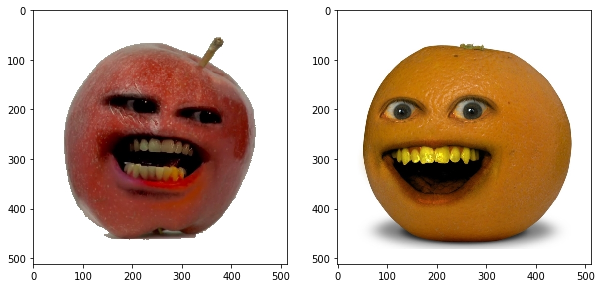

In [3]:
plt.figure(figsize = (10,5));
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(apple, cv2.COLOR_BGR2RGB));
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB));

Hopefully combining them will create something less annoying. First take half of each image.

In [4]:
apple_left = apple[:,:256,:]; print(apple_left.shape)
orange_right = orange[:,256:,:]; print(orange_right.shape)

(512, 256, 3)
(512, 256, 3)


Initially the stacked image looks like the one below.

In [5]:
stacked = np.hstack((apple_left, orange_right)); print(stacked.shape)

(512, 512, 3)


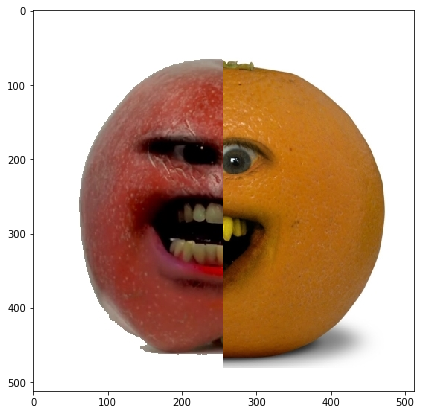

In [6]:
plt.figure(figsize = (7,7));
plt.imshow(cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB));

Create progressive scaled down layers of each fruit. Each one has the half the dimenions of the image above.

In [7]:
def createImagePyramid(img, n_layers):
    layer = img.copy()
    output_pyramid = [layer]
    for i in range(n_layers - 1):
        layer = cv2.pyrDown(layer)
        output_pyramid.append(layer)
    return output_pyramid

In [8]:
gaussian_apple_pyram = createImagePyramid(apple, 6)
gaussian_orange_pyram = createImagePyramid(orange, 6)

The laplacian Pyramid is a series of the diffence between a layer and the laplacian of the layer above it.

In [9]:
def createLaplacianPyramid(gaussian_pyramid):
    output_pyramid = [gaussian_pyramid[-1]]
    for i in range(len(gaussian_pyramid) - 1, 0, -1):
        gaussian_expand = cv2.pyrUp(gaussian_pyramid[i])
        layer_diff = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expand)
        output_pyramid.append(layer_diff)
    return output_pyramid

In [10]:
laplacian_apple_pyrim = createLaplacianPyramid(gaussian_apple_pyram)
laplacian_orange_pyrim = createLaplacianPyramid(gaussian_orange_pyram)

Create a combined image using the two sides of the laplacian pyramid.

In [11]:
def mergeTwoPyramids(pyramid1, pyramid2):
    combined_pyram = []
    for layer1, layer2 in zip(laplacian_apple_pyrim, laplacian_orange_pyrim):
        col1, row1, ch1 = layer1.shape; col2, row2, ch2 = layer2.shape
        assert(col1 == col2); assert(row1 == row2); assert(ch1 == ch2)
        merged_layer = np.hstack((layer1[:,:(col1//2),:], layer2[:,(col2//2):,:]))
        combined_pyram.append(merged_layer)
    return combined_pyram

In [12]:
apple_orange_pyramid = mergeTwoPyramids(laplacian_apple_pyrim, laplacian_orange_pyrim)

Reconstruct the pyramid from the bottom up. We start with an image that is 16 by 16 in this case. The reverse operation is done to subtracting the differences of Gaussian.

In [13]:
def constructImageFromPyramid(pyramid):
    output_img = pyramid[0]
    for layer in pyramid[1:]:
        output_img = cv2.pyrUp(output_img)
        output_img = cv2.add(layer, output_img)
    return output_img

In [14]:
reconstructed_image = constructImageFromPyramid(apple_orange_pyramid)

The top edge looks but there is a mismatch between the bottom edges. The background bleeds into the edges of the two fruits. Sadly the resulting fruit is even more annoying than before.

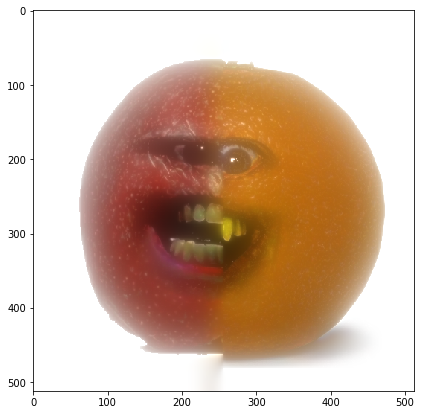

In [15]:
plt.figure(figsize = (7,7));
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB));